In [1]:
# IMPORTS

# Torch
import torch
import torchinfo
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# ML-related
from scipy.io import loadmat
import matplotlib.pyplot as plt

# Default Python
import random
from pathlib import Path

# Other Libraries
from PIL import Image
from tqdm import tqdm

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass

In [3]:
# Grabbing data and initial parsing

root_dir = Path('/kaggle/input/stanford-cars-dataset')
cars_annos = root_dir / 'cars_annos.mat'
cars_test = root_dir / 'cars_test' / 'cars_test'
cars_train = root_dir / 'cars_train' / 'cars_train'

cars_annos_mat = loadmat(cars_annos)
training_images = os.listdir(cars_train)
testing_images = os.listdir(cars_test)

device = "cuda" if torch.cuda.is_available() else "cpu"

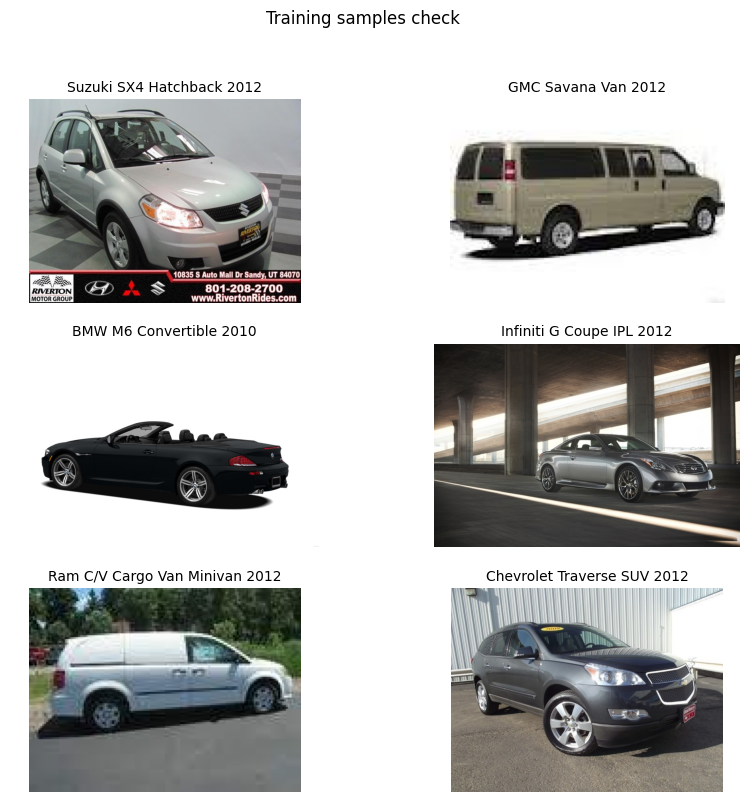

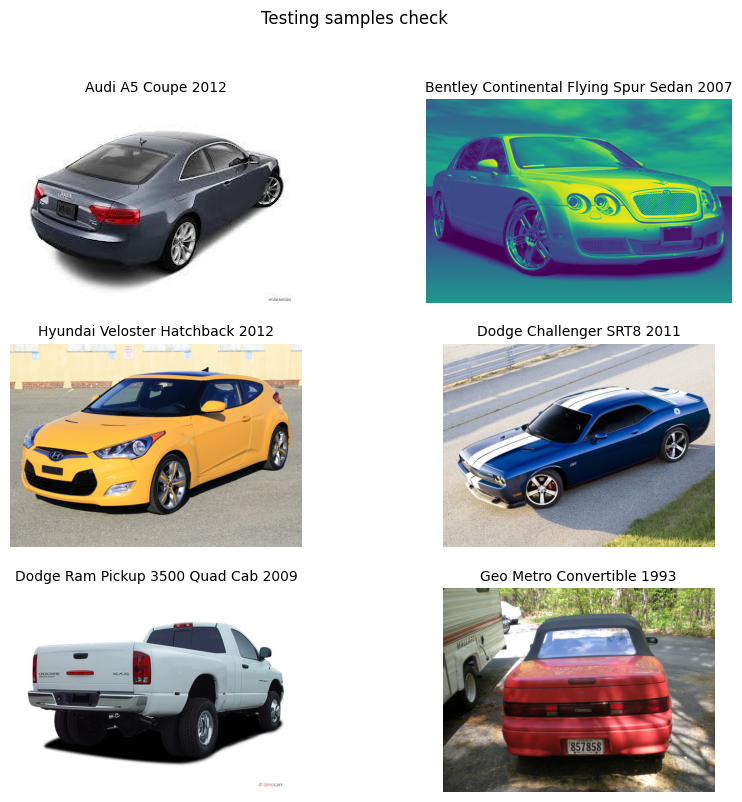

In [4]:
# New mat files

root_dir = Path("/kaggle/input/standford-cars-dataset-meta/")
cars_annos_train = root_dir / "devkit" / "cars_train_annos.mat"
cars_annos_test = root_dir / "cars_test_annos_withlabels (1).mat"

cars_meta_mat = loadmat(root_dir / "devkit" / "cars_meta.mat")
cars_annos_train_mat, cars_annos_test_mat = loadmat(cars_annos_train), loadmat(cars_annos_test)

class_names = [arr[0] for arr in cars_meta_mat['class_names'][0]]

# New structure of mat file's "annotations array is going to be" 6 elements with
# box11, box12, box21, box22, class, and filename

sample1 = cars_annos_train_mat['annotations'][0][0]
sample1_path, sample1_class = sample1[-1][0], sample1[-2][0][0] - 1

# Running the same "Image.open()" code as before works now and we have the correct filepaths
# and labels. We're good to go

# Check 3 examples for training and 3 for testing before proceeding
# print(class_names[sample1_class])
# Image.open(os.path.join(cars_train, sample1_path))

w, h = 2, 3
fig, axes_list = plt.subplots(h, w, figsize=(5*w, 3*h)) 
fig.suptitle('Training samples check')

for axes in axes_list:
    for ax in axes:
        ax.axis('off')
        random_index = random.randint(0, 500)
        random_sample = cars_annos_train_mat['annotations'][0][random_index]
        sample_path, sample_class = random_sample[-1][0], random_sample[-2][0][0] - 1
        im = Image.open(os.path.join(cars_train, sample_path))
        ax.imshow(im)
        ax.set_title(class_names[sample_class], fontdict={"fontsize": 10})

fig, axes_list = plt.subplots(h, w, figsize=(5*w, 3*h)) 
fig.suptitle('Testing samples check')

for axes in axes_list:
    for ax in axes:
        ax.axis('off')
        random_index = random.randint(0, 500)
        random_sample = cars_annos_test_mat['annotations'][0][random_index]
        sample_path, sample_class = random_sample[-1][0], random_sample[-2][0][0] - 1
        im = Image.open(os.path.join(cars_test, sample_path))
        ax.imshow(im)
        ax.set_title(class_names[sample_class], fontdict={"fontsize": 10})

In [5]:
# Looking good so far. Now we're ready to define our model, transformations, datasets, dataloaders, and training/testing loop

model_weights = torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
model = torchvision.models.mobilenet_v3_small(weights=model_weights).to(device)
model_transforms = model_weights.transforms()

#for param in model.parameters():
 #  param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(in_features=1024, out_features=len(class_names), bias=True)
).to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 94.4MB/s]


In [6]:
# Datasets - create custom dataset and a dictionary which relates image path to label

training_image_label_dictionary, testing_image_label_dictionary = {}, {}

for arr in cars_annos_train_mat['annotations'][0]:
    image, label = arr[-1][0], arr[-2][0][0] - 1
    training_image_label_dictionary[image] = label

for arr in cars_annos_test_mat['annotations'][0]:
    image, label = arr[-1][0], arr[-2][0][0] - 1
    testing_image_label_dictionary[image] = label

# Using these data structures, we'll be able to return an image and a label easily in our custom dataset as we'll see in a bit
print(len(training_image_label_dictionary), len(testing_image_label_dictionary))

8144 8041


In [7]:
class StanfordCarsCustomDataset(Dataset):
    def __init__(self, directory, image_label_dict, transforms):
        super().__init__()

        self.images = [os.path.join(directory, f) for f in os.listdir(directory)]
        self.transforms = transforms
        self.image_label_dict = image_label_dict

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # Get image
        image = self.images[index]
        img_pil = Image.open(image).convert('RGB')
        img_trans = self.transforms(img_pil)

        # Parse out the label from cars_meta and cars_x_annos files
        image_stem = image.split("/")[-1]
        img_label = self.image_label_dict[image_stem]

        return img_trans, img_label

In [8]:
train_dset = StanfordCarsCustomDataset(cars_train, training_image_label_dictionary, model_transforms)
test_dset = StanfordCarsCustomDataset(cars_test, testing_image_label_dictionary, model_transforms)

train_dloader = DataLoader(train_dset, batch_size=64, shuffle=True, num_workers=4)
test_dloader = DataLoader(test_dset, batch_size=64, num_workers=4)

In [9]:
# Set up loss function, optmizer, and training/testing loops

loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
epochs = 40

for epoch in tqdm(range(epochs)):
    model.train()
    train_loss, train_acc = 0, 0
    
    # Training loop
    for (X, y) in train_dloader:
        X, y = X.to(device), y.to(device)
        
        y_logits = model(X)
        y_pred_labels = torch.softmax(y_logits, dim=1).argmax(dim=1)
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()
        train_acc += (y == y_pred_labels).sum().item() / len(y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
    train_loss /= len(train_dloader)
    train_acc /= len(train_dloader)
    
    # Testing loop
    model.eval()
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for (A, b) in test_dloader:
            A, b = A.to(device), b.to(device)
            b_logits = model(A)
            b_pred_labels = torch.softmax(b_logits, dim=1).argmax(dim=1)
            test_loss += loss_fn(b_logits, b).item()
            test_acc += (b == b_pred_labels).sum().item() / len(b)
            
    test_loss /= len(test_dloader)
    test_acc /= len(test_dloader)
        
    print(f"Epoch: {epoch} -> TrainLoss, TrainAcc: {train_loss}, {train_acc} && TestLoss, TestAcc: {test_loss}, {test_acc}")

  2%|▎         | 1/40 [01:24<55:12, 84.93s/it]

Epoch: 0 -> TrainLoss, TrainAcc: 5.356045015156269, 0.0716552734375 && TestLoss, TestAcc: 4.6905567286506535, 0.12603743224932248


  5%|▌         | 2/40 [02:35<48:37, 76.77s/it]

Epoch: 1 -> TrainLoss, TrainAcc: 3.2924283295869827, 0.3839111328125 && TestLoss, TestAcc: 3.7352472013897366, 0.30470867208672087


  8%|▊         | 3/40 [03:46<45:41, 74.10s/it]

Epoch: 2 -> TrainLoss, TrainAcc: 2.2315954780206084, 0.6715087890625 && TestLoss, TestAcc: 2.863381308222574, 0.5039259097948122


 10%|█         | 4/40 [04:57<43:34, 72.63s/it]

Epoch: 3 -> TrainLoss, TrainAcc: 1.754513431340456, 0.8240966796875 && TestLoss, TestAcc: 2.8054915477359104, 0.512745596205962


 12%|█▎        | 5/40 [06:08<42:04, 72.14s/it]

Epoch: 4 -> TrainLoss, TrainAcc: 1.4814362917095423, 0.9185791015625 && TestLoss, TestAcc: 2.666579308963957, 0.5641544473480449


 15%|█▌        | 6/40 [07:20<40:44, 71.91s/it]

Epoch: 5 -> TrainLoss, TrainAcc: 1.3569502718746662, 0.9578857421875 && TestLoss, TestAcc: 2.6346358287902105, 0.5716644889663183


 18%|█▊        | 7/40 [08:30<39:22, 71.60s/it]

Epoch: 6 -> TrainLoss, TrainAcc: 1.2813504841178656, 0.9783935546875 && TestLoss, TestAcc: 2.5853428310818143, 0.6079141260162602


 20%|██        | 8/40 [09:41<38:05, 71.41s/it]

Epoch: 7 -> TrainLoss, TrainAcc: 1.2398216184228659, 0.986572265625 && TestLoss, TestAcc: 2.4925191572734287, 0.6336382113821138


 22%|██▎       | 9/40 [10:53<36:52, 71.36s/it]

Epoch: 8 -> TrainLoss, TrainAcc: 1.2048571044579148, 0.9931640625 && TestLoss, TestAcc: 2.4748626436506, 0.6449138598528843


 25%|██▌       | 10/40 [12:04<35:38, 71.27s/it]

Epoch: 9 -> TrainLoss, TrainAcc: 1.1936279544606805, 0.9931640625 && TestLoss, TestAcc: 2.5318100471345204, 0.6375822686798296


 28%|██▊       | 11/40 [13:16<34:31, 71.42s/it]

Epoch: 10 -> TrainLoss, TrainAcc: 1.1862198635935783, 0.9945068359375 && TestLoss, TestAcc: 2.5632595031980485, 0.6134400406504066


 30%|███       | 12/40 [14:27<33:17, 71.33s/it]

Epoch: 11 -> TrainLoss, TrainAcc: 1.174551977775991, 0.995849609375 && TestLoss, TestAcc: 2.527310329770285, 0.6438522309330236


 32%|███▎      | 13/40 [15:38<32:06, 71.34s/it]

Epoch: 12 -> TrainLoss, TrainAcc: 1.1638286774978042, 0.9967041015625 && TestLoss, TestAcc: 2.5586684525959074, 0.6412873838559814


 35%|███▌      | 14/40 [16:49<30:49, 71.12s/it]

Epoch: 13 -> TrainLoss, TrainAcc: 1.1660054791718721, 0.9962158203125 && TestLoss, TestAcc: 2.5910807412768166, 0.6371709252806813


 38%|███▊      | 15/40 [18:00<29:40, 71.23s/it]

Epoch: 14 -> TrainLoss, TrainAcc: 1.170826124958694, 0.9951171875 && TestLoss, TestAcc: 2.5226816960743497, 0.641837858110724


 40%|████      | 16/40 [19:10<28:22, 70.94s/it]

Epoch: 15 -> TrainLoss, TrainAcc: 1.1714123897254467, 0.9951171875 && TestLoss, TestAcc: 2.6774848321127513, 0.6188419473480449


 42%|████▎     | 17/40 [20:21<27:10, 70.88s/it]

Epoch: 16 -> TrainLoss, TrainAcc: 1.1642081374302506, 0.9967041015625 && TestLoss, TestAcc: 2.6216879799252464, 0.631769018583043


 45%|████▌     | 18/40 [21:32<25:57, 70.77s/it]

Epoch: 17 -> TrainLoss, TrainAcc: 1.1611197590827942, 0.9954833984375 && TestLoss, TestAcc: 2.556193832367186, 0.64798381242741


 48%|████▊     | 19/40 [22:42<24:45, 70.74s/it]

Epoch: 18 -> TrainLoss, TrainAcc: 1.159574351273477, 0.996337890625 && TestLoss, TestAcc: 2.609807124213567, 0.6452556378242353


 50%|█████     | 20/40 [23:54<23:38, 70.91s/it]

Epoch: 19 -> TrainLoss, TrainAcc: 1.1616005273535848, 0.995849609375 && TestLoss, TestAcc: 2.5379570779346285, 0.6414658343012002


 52%|█████▎    | 21/40 [25:05<22:29, 71.02s/it]

Epoch: 20 -> TrainLoss, TrainAcc: 1.1549971643835306, 0.9964599609375 && TestLoss, TestAcc: 2.592107750120617, 0.6408609175377468


 55%|█████▌    | 22/40 [26:16<21:17, 70.98s/it]

Epoch: 21 -> TrainLoss, TrainAcc: 1.1655896287411451, 0.99462890625 && TestLoss, TestAcc: 2.599249741387746, 0.6447596060782036


 57%|█████▊    | 23/40 [27:26<20:03, 70.79s/it]

Epoch: 22 -> TrainLoss, TrainAcc: 1.1487993746995926, 0.996337890625 && TestLoss, TestAcc: 2.707670433180673, 0.6345909552845528


 60%|██████    | 24/40 [28:36<18:49, 70.61s/it]

Epoch: 23 -> TrainLoss, TrainAcc: 1.1531760962679982, 0.9957275390625 && TestLoss, TestAcc: 2.534307320912679, 0.6623445363917925


 62%|██████▎   | 25/40 [29:47<17:41, 70.77s/it]

Epoch: 24 -> TrainLoss, TrainAcc: 1.1511350683867931, 0.9962158203125 && TestLoss, TestAcc: 2.563445571869139, 0.6492238917924893


 65%|██████▌   | 26/40 [30:58<16:30, 70.77s/it]

Epoch: 25 -> TrainLoss, TrainAcc: 1.1517456322908401, 0.99658203125 && TestLoss, TestAcc: 2.580262925889757, 0.6527808023615951


 68%|██████▊   | 27/40 [32:09<15:20, 70.81s/it]

Epoch: 26 -> TrainLoss, TrainAcc: 1.148111187852919, 0.9959716796875 && TestLoss, TestAcc: 2.5555512980809287, 0.6557721157568719


 70%|███████   | 28/40 [33:20<14:09, 70.81s/it]

Epoch: 27 -> TrainLoss, TrainAcc: 1.145929729565978, 0.9970703125 && TestLoss, TestAcc: 2.6969804763793945, 0.6238567073170732


 72%|███████▎  | 29/40 [34:31<13:00, 70.93s/it]

Epoch: 28 -> TrainLoss, TrainAcc: 1.140873926691711, 0.9974365234375 && TestLoss, TestAcc: 2.554995370289636, 0.655454534456059


 75%|███████▌  | 30/40 [35:42<11:48, 70.82s/it]

Epoch: 29 -> TrainLoss, TrainAcc: 1.1420876570045948, 0.996826171875 && TestLoss, TestAcc: 2.581542229841626, 0.650920683313976


 78%|███████▊  | 31/40 [36:52<10:36, 70.73s/it]

Epoch: 30 -> TrainLoss, TrainAcc: 1.145447501912713, 0.99609375 && TestLoss, TestAcc: 2.455189336859991, 0.6730485385210995


 80%|████████  | 32/40 [38:03<09:25, 70.69s/it]

Epoch: 31 -> TrainLoss, TrainAcc: 1.1396293211728334, 0.9967041015625 && TestLoss, TestAcc: 2.726292884539044, 0.6332571138211383


 82%|████████▎ | 33/40 [39:14<08:15, 70.85s/it]

Epoch: 32 -> TrainLoss, TrainAcc: 1.1404646812006831, 0.996826171875 && TestLoss, TestAcc: 2.465300616763887, 0.6731332268679829


 85%|████████▌ | 34/40 [40:24<07:03, 70.61s/it]

Epoch: 33 -> TrainLoss, TrainAcc: 1.1330760242417455, 0.997314453125 && TestLoss, TestAcc: 2.589444080988566, 0.6633759194734804


 88%|████████▊ | 35/40 [41:35<05:53, 70.66s/it]

Epoch: 34 -> TrainLoss, TrainAcc: 1.133475448936224, 0.997314453125 && TestLoss, TestAcc: 2.59448378237467, 0.6604148519163764


 90%|█████████ | 36/40 [42:46<04:43, 70.83s/it]

Epoch: 35 -> TrainLoss, TrainAcc: 1.1266542645171285, 0.9970703125 && TestLoss, TestAcc: 2.5494623051749334, 0.6714364353464962


 92%|█████████▎| 37/40 [43:57<03:32, 70.73s/it]

Epoch: 36 -> TrainLoss, TrainAcc: 1.1305454783141613, 0.9969482421875 && TestLoss, TestAcc: 2.5535421958045355, 0.6764814411536972


 95%|█████████▌| 38/40 [45:07<02:21, 70.74s/it]

Epoch: 37 -> TrainLoss, TrainAcc: 1.1272206790745258, 0.99755859375 && TestLoss, TestAcc: 2.517401659299457, 0.6681729094076655


 98%|█████████▊| 39/40 [46:18<01:10, 70.75s/it]

Epoch: 38 -> TrainLoss, TrainAcc: 1.1264340868219733, 0.99755859375 && TestLoss, TestAcc: 2.4887094743668086, 0.6889518002322881


100%|██████████| 40/40 [47:30<00:00, 71.25s/it]

Epoch: 39 -> TrainLoss, TrainAcc: 1.122823853045702, 0.998046875 && TestLoss, TestAcc: 2.5195830218375677, 0.6842243757259001


In [10]:
# Doing some inference from the test set

#with torch.inference_mode():
 #   imgs, labels = next(iter(test_dloader))
  #  imgs_transformed = model_transforms(imgs)
    
#    logits = model(imgs_transformed.to(device))
#    pred_probs = torch.softmax(logits, dim=1)
#    pred_label = torch.argmax(pred_probs, dim=1)

#w, h = 4, 8
#fig, axes_list = plt.subplots(h, w, figsize=(25, 40)) 
#fig.suptitle('Inference on one batch')

#axes_list = axes_list.flatten()

#for i, img in enumerate(imgs):
#    axes_list[i].imshow(img.permute(1, 2, 0))
#    axes_list[i].axis('off')
#    axes_list[i].set(title=f"Actual: {class_names[labels[i] - 1]}\n Predicted: {class_names[pred_label[i] - 1]}")


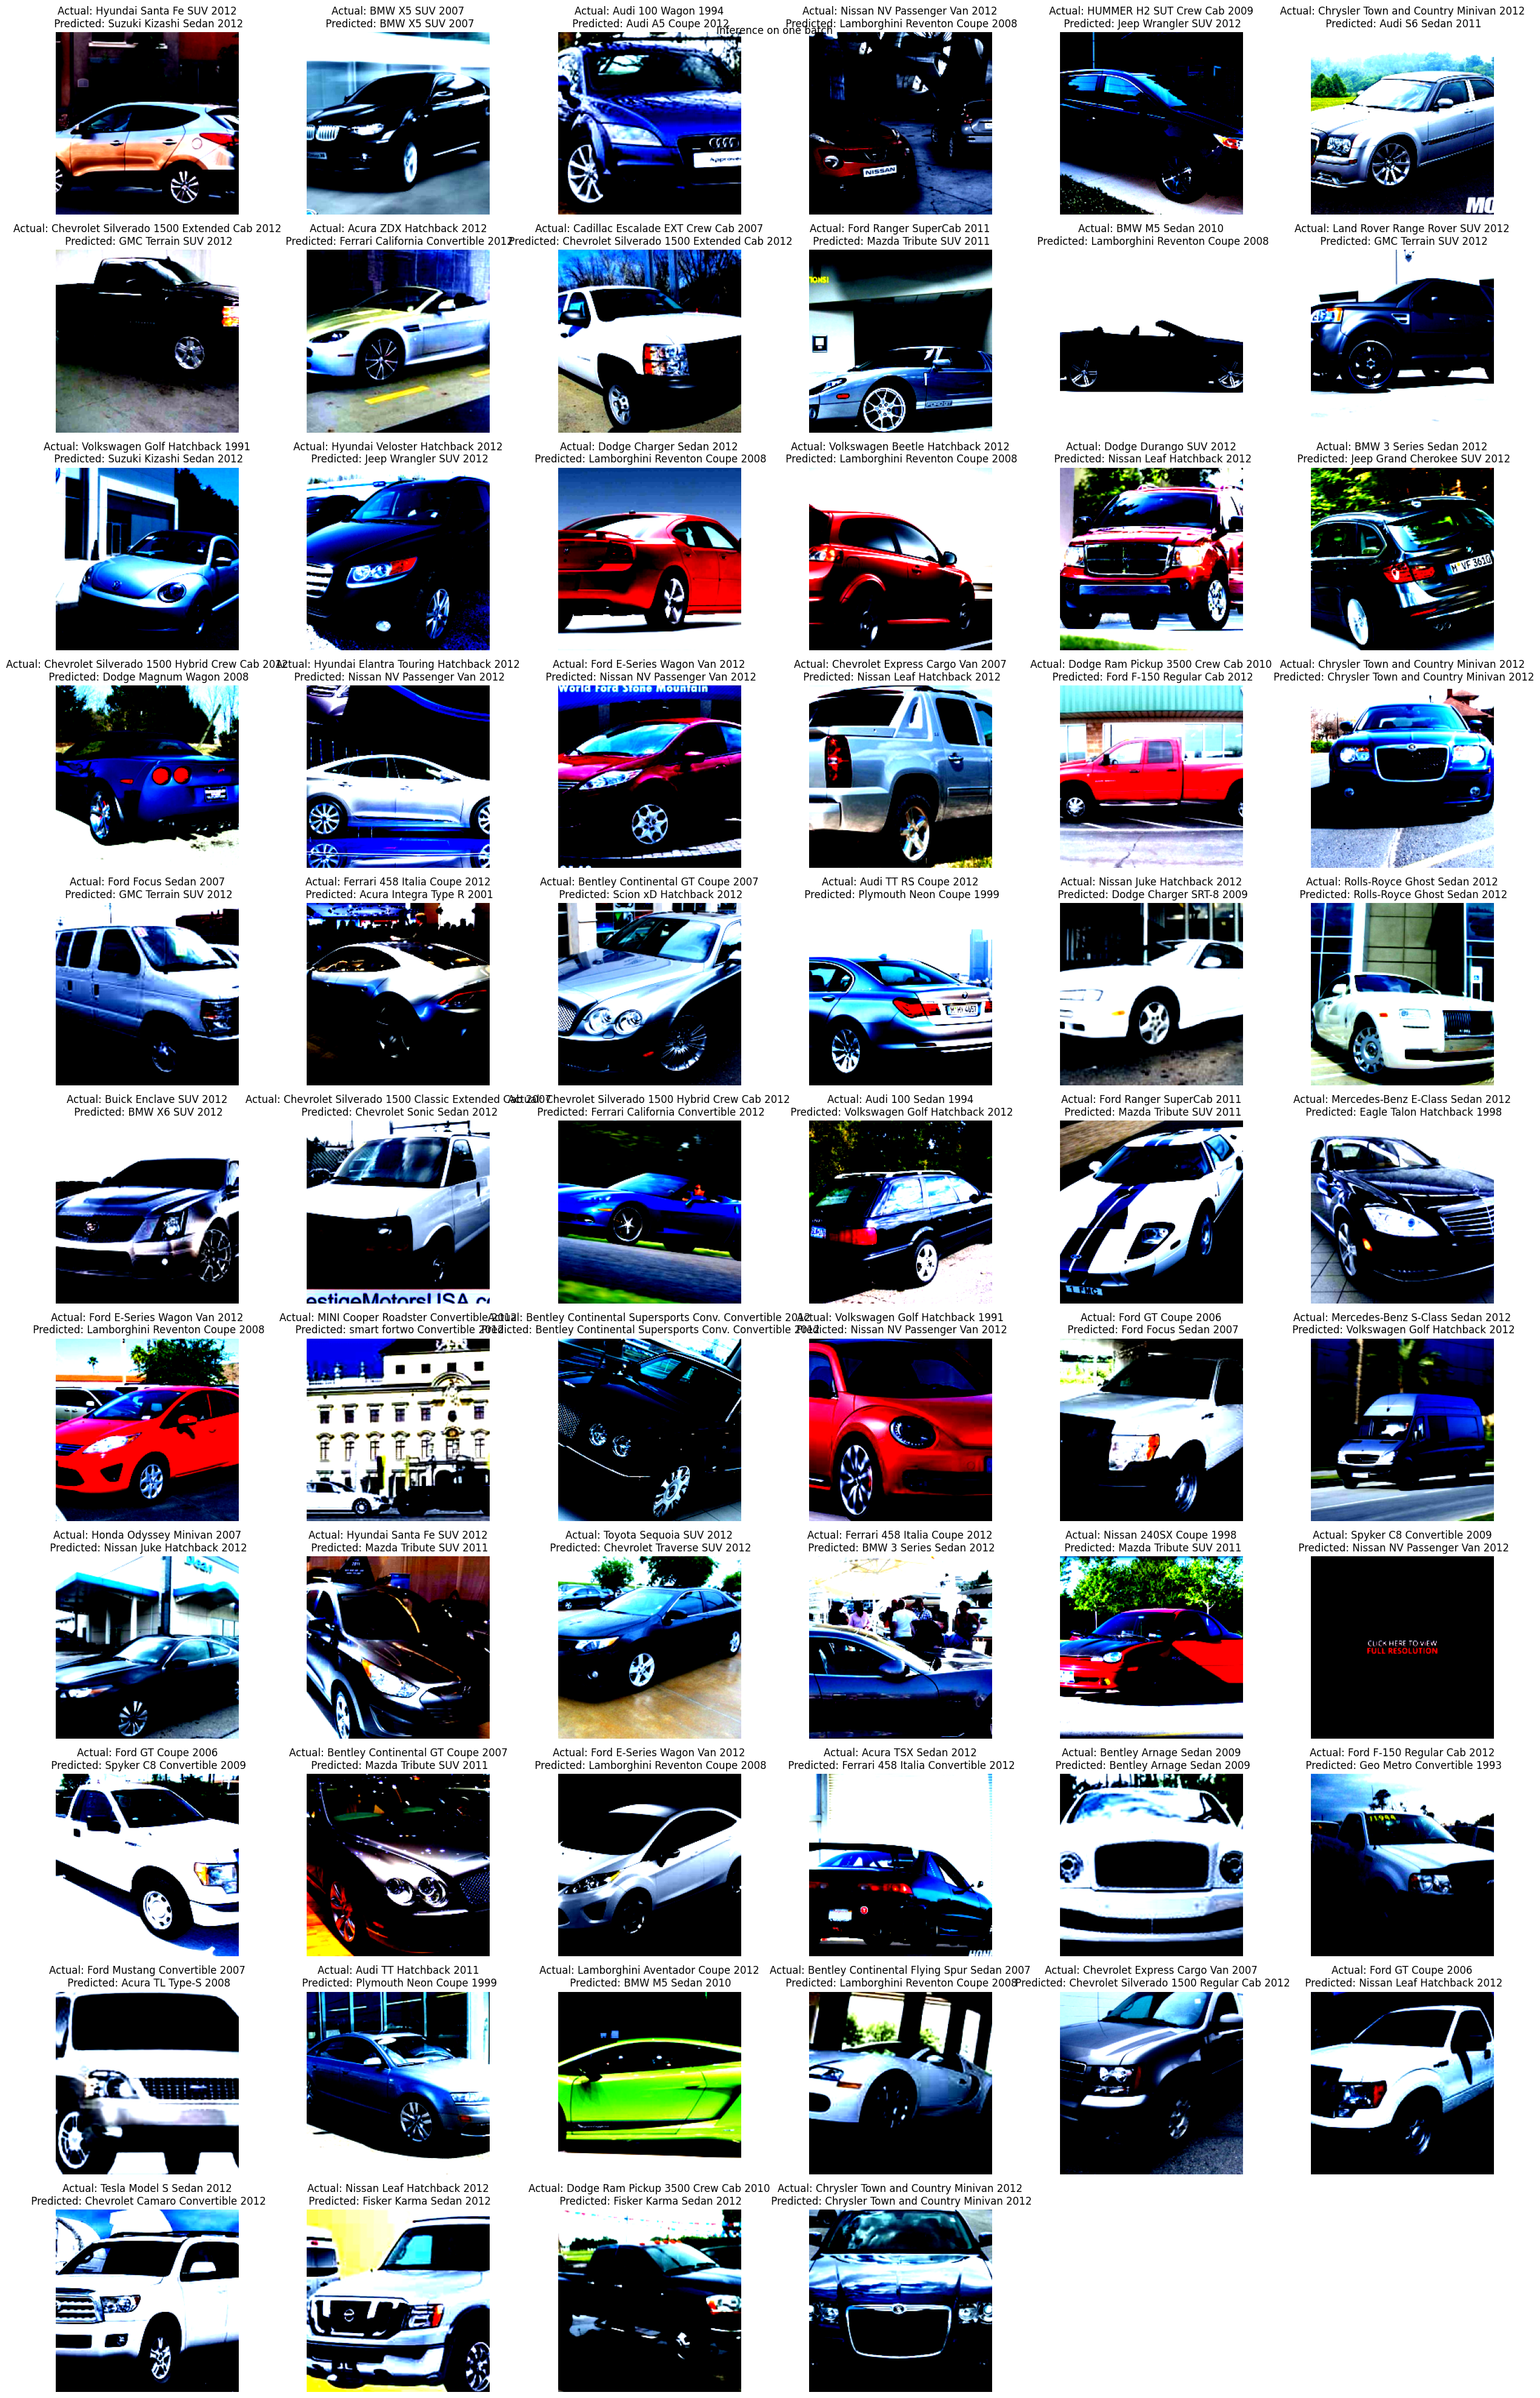

In [11]:
import matplotlib.pyplot as plt

with torch.inference_mode():
    # Get a batch of images and labels
    imgs, labels = next(iter(test_dloader))
    imgs_transformed = model_transforms(imgs)

    # Perform inference
    logits = model(imgs_transformed.to(device))
    pred_probs = torch.softmax(logits, dim=1)
    pred_label = torch.argmax(pred_probs, dim=1)

# Define the dimensions of the subplot grid
w, h = 6, 11  # Adjusted to ensure sufficient layout for 64 images
fig, axes_list = plt.subplots(h, w, figsize=(25, 40)) 
fig.suptitle('Inference on one batch')

# Flatten the axes list for easy iteration
axes_list = axes_list.flatten()

# Iterate only over the number of images you received (up to the size of your axes)
for i in range(min(len(imgs), len(axes_list))):
    img = imgs[i]
    axes_list[i].imshow(img.permute(1, 2, 0).cpu())  # Permute dimensions and move to CPU if necessary
    axes_list[i].axis('off')
    axes_list[i].set(title=f"Actual: {class_names[labels[i] - 1]}\n Predicted: {class_names[pred_label[i] - 1]}")

# Hide any unused subplots if there are less than 64 images
for j in range(len(imgs), len(axes_list)):
    axes_list[j].axis('off')  # Turn off unused axes
    
plt.tight_layout()
plt.show()